In [58]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical

In [59]:
NUM_CLASSES = 10
LOSS = 'categorical_crossentropy'
OPTIMIZER = 'adam'
TEST_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 5

## Load dataset

In [61]:
(x_train_raw, y_train_raw),(x_test_raw, y_test_raw) = keras.datasets.mnist.load_data()

img_count_train = x_train_raw.shape[0]
img_count_test = x_test_raw.shape[0]
img_x_dim = x_train_raw.shape[1]
img_y_dim = x_train_raw.shape[2]

## Confirm handwritten image vs truth

Handwritten sample #52791 is a '7'


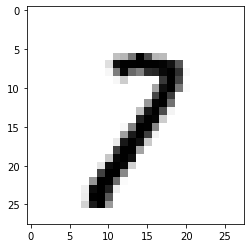

In [62]:
i = random.randrange(img_count_train)
print(f"Handwritten sample #{i} is a '{y_train_raw[i]}'")
plt.imshow(x_train_raw[i], cmap='gray_r', vmin = 0, vmax = 255);

## Pre-processing

#### Reshape input data
Input data is N X\*Y sized images in the form of [N, X, Y]. So reshape into N X\*Y shaped rows.

In [63]:
x_train = np.reshape(x_train_raw, (img_count_train, img_x_dim * img_y_dim))
x_test = np.reshape(x_test_raw, (img_count_test, img_x_dim * img_y_dim))

#### Encode truth data
Truth data needs to be one-hot encoded

In [64]:
y_train = to_categorical(y_train_raw, NUM_CLASSES)
y_test = to_categorical(y_test_raw, NUM_CLASSES)

print(y_train_raw[i:i+5])
print('  -------------------')
print(f"#{[0,1,2,3,4,5,6,7,8,9]}")
print(y_train[i:i+5])

[7 5 0 3 9]
  -------------------
#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Define model

In [65]:
def mnist_model(X, y, epochs, batch_size, model_layout):
    
    # create train & val sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SPLIT, shuffle=True)
    
    # define model
    model = Sequential()
    
    # first dense layer
    model.add(Dense(model_layout[0], input_dim=img_x_dim * img_y_dim, activation='relu'))

    # remaining dense layers
    depth = len(model_layout)
    for width in model_layout[1:]:
        model.add(Dense(width, activation='relu'))

    # output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # compile the model
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])


    # train (fit) the model to the dataset
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    # plot loss during training
    plt.title('Loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    return model


Epoch 1/5
  7/422 [..............................] - ETA: 4s - loss: 32.1652 - accuracy: 0.2779   

2022-08-07 17:32:35.211332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 1.6683 - accuracy: 0.6289

2022-08-07 17:32:39.139935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 4s 10ms/step - loss: 1.6683 - accuracy: 0.6289 - val_loss: 0.7739 - val_accuracy: 0.7958
Epoch 2/5
422/422 [==============================] - 4s 10ms/step - loss: 0.4521 - accuracy: 0.8900 - val_loss: 0.3954 - val_accuracy: 0.9162
Epoch 3/5
422/422 [==============================] - 4s 10ms/step - loss: 0.2464 - accuracy: 0.9398 - val_loss: 0.2644 - val_accuracy: 0.9350
Epoch 4/5
422/422 [==============================] - 4s 10ms/step - loss: 0.1690 - accuracy: 0.9575 - val_loss: 0.2183 - val_accuracy: 0.9523
Epoch 5/5
422/422 [==============================] - 4s 10ms/step - loss: 0.1237 - accuracy: 0.9677 - val_loss: 0.1866 - val_accuracy: 0.9572


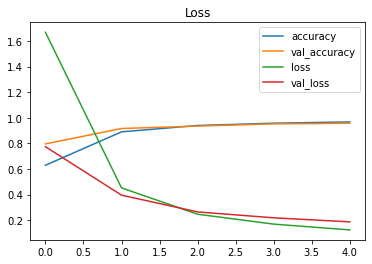

In [66]:
my_model = mnist_model(x_train, y_train, EPOCHS, BATCH_SIZE, [784, 784/4, 784/16])

## Evaluate model

In [82]:
# make probability predictions with the model
predictions = my_model.predict(x_test)
pred_labels = np.argmax(predictions, axis=1)

# evaluate the keras model
_, train_mse = my_model.evaluate(x_train, y_train, verbose=0)
_, test_mse = my_model.evaluate(x_test, y_test, verbose=0)

print('Train MSE:  %.4f' % train_mse)
print('Test MSE:  %.4f' % test_mse)

# save off the wrong predictions
wrong_predictions = x_test_raw[pred_labels != y_test_raw]
wrong_labels = pred_labels[pred_labels != y_test_raw]
right_labels = y_test_raw[pred_labels != y_test_raw]

# Characterize amount of wrongness
percent_wrong = wrong_predictions.shape[0]/x_test.shape[0]*100
print(f"Number Wrongly Predicted:  {wrong_predictions.shape[0]}")
print(f"Percent Wrong Predictions: {percent_wrong:.2f}%")

313/313 [==============================] - 1s 2ms/step
Train MSE:  0.9715
Test MSE:  0.9600
Number Wrongly Predicted:  400
Percent Wrong Predictions: 4.00%


#### Review wrong predictions

Handwritten sample #13:
 - Predicted: '7'
 - Actual:     '3'


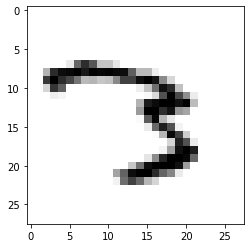

In [85]:
random_wrong = random.randrange(wrong_predictions.shape[0])
print(f"Handwritten sample #{random_wrong}:")
print(f" - Predicted: '{wrong_labels[random_wrong]}'")
print(f" - Actual:     '{right_labels[random_wrong]}'")
plt.imshow(wrong_predictions[random_wrong], cmap='gray_r', vmin = 0, vmax = 255);